In [2]:
from __future__ import print_function
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
from IPython.core.debugger import Tracer
import matplotlib.pyplot as plt
from torchvision import utils

In [3]:
def imshow(inp, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(5, 5))
    inp = transforms.ToPILImage()(inp)
    plt.imshow(inp,cmap='gray')
    plt.show()

In [4]:
class MLP_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu):
        super(MLP_G, self).__init__()
        self.ngpu = ngpu

        main = nn.Sequential(
            # Z goes into a linear of size: ngf
            nn.Linear(nz, ngf),
            #nn.ReLU(True),
            #nn.Linear(ngf, ngf),
            #nn.ReLU(True),
            #nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, nc * isize * isize),
        )
        self.main = main
        self.nc = nc
        self.isize = isize
        self.nz = nz

    def forward(self, input):
        input = input.view(input.size(0), input.size(1))
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(output.size(0), self.nc, self.isize, self.isize)

In [5]:
class MLP_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu):
        super(MLP_D, self).__init__()
        self.ngpu = ngpu

        main = nn.Sequential(
            # Z goes into a linear of size: ndf
            nn.Linear(nc * isize * isize, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, 1),
        )
        self.main = main
        self.nc = nc
        self.isize = isize
        self.nz = nz

    def forward(self, input):
        input = input.view(input.size(0),
                           input.size(1) * input.size(2) * input.size(3))
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        output = output.mean(0)
        return output.view(1)

In [6]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu, n_extra_layers=0):
        super(DCGAN_D, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        main = nn.Sequential()
        # input is nc x isize x isize
        main.add_module('initial.conv.{0}-{1}'.format(nc, ndf),
                        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
        main.add_module('initial.relu.{0}'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        csize, cndf = isize / 2, ndf

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cndf),
                            nn.Conv2d(cndf, cndf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, cndf),
                            nn.BatchNorm2d(cndf))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cndf),
                            nn.LeakyReLU(0.2, inplace=True))

        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            main.add_module('pyramid.{0}-{1}.conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
            main.add_module('pyramid.{0}.batchnorm'.format(out_feat),
                            nn.BatchNorm2d(out_feat))
            main.add_module('pyramid.{0}.relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        main.add_module('final.{0}-{1}.conv'.format(cndf, 1),
                        nn.Conv2d(cndf, 1, 4, 1, 0, bias=False))
        self.main = main


    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else: 
            output = self.main(input)
            
        output = output.mean(0)
        return output.view(1)

In [7]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu, n_extra_layers=0):
        super(DCGAN_G, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2

        main = nn.Sequential()
        # input is Z, going into a convolution
        main.add_module('initial.{0}-{1}.convt'.format(nz, cngf),
                        nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
        main.add_module('initial.{0}.batchnorm'.format(cngf),
                        nn.BatchNorm2d(cngf))
        main.add_module('initial.{0}.relu'.format(cngf),
                        nn.ReLU(True))

        csize, cndf = 4, cngf
        while csize < isize//2:
            main.add_module('pyramid.{0}-{1}.convt'.format(cngf, cngf//2),
                            nn.ConvTranspose2d(cngf, cngf//2, 4, 2, 1, bias=False))
            main.add_module('pyramid.{0}.batchnorm'.format(cngf//2),
                            nn.BatchNorm2d(cngf//2))
            main.add_module('pyramid.{0}.relu'.format(cngf//2),
                            nn.ReLU(True))
            cngf = cngf // 2
            csize = csize * 2

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cngf),
                            nn.Conv2d(cngf, cngf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, cngf),
                            nn.BatchNorm2d(cngf))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cngf),
                            nn.ReLU(True))

        main.add_module('final.{0}-{1}.convt'.format(cngf, nc),
                        nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        main.add_module('final.{0}.tanh'.format(nc),
                        nn.Tanh())
        self.main = main

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else: 
            output = self.main(input)
        return output 

In [8]:
def cost_matrix(x, y,p=2) :
    "Returns the matrix of $|x_i-y_j|^p$."
    x_col = x.unsqueeze(1) 
    y_lin = y.unsqueeze(0)
    c = torch.sum( (torch.abs(x_col - y_lin))**p , 2) 
    return c 

In [132]:
def sinkhorn_loss(x, y, epsilon, n, niter):
    """
    Given two emprical measures with n points each with locations x and y
    outputs an approximation of the OT cost with regularization parameter epsilon
    niter is the max. number of steps in sinkhorn loop
    """
    # The Sinkhorn algorithm takes as input three variables :
    C = cost_matrix(x, y)/n  # Wasserstein cost function

    # both marginals are fixed with equal weights
    if cuda:
        mu = Variable(
            1. / n * torch.cuda.FloatTensor(n).fill_(1), requires_grad=False)
        nu = Variable(
            1. / n * torch.cuda.FloatTensor(n).fill_(1), requires_grad=False)
    else:
        mu = Variable(
            1. / n * torch.FloatTensor(n).fill_(1), requires_grad=False)
        nu = Variable(
            1. / n * torch.FloatTensor(n).fill_(1), requires_grad=False)

    # Parameters of the Sinkhorn algorithm.
    rho = 1  #(.5) **2          # unbalanced transport
    tau = -.8  # nesterov-like acceleration
    lam = rho / (rho + epsilon)  # Update exponent
    thresh = 10**(-1)  # stopping criterion

    # Elementary operations .....................................................................
    def ave(u, u1):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

    def M(u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(1) + v.unsqueeze(0)) / epsilon

    def lse(A):
        "log-sum-exp"
        return torch.log(torch.exp(A).sum(1, keepdim=True) +
                         1e-6)  # add 10^-6 to prevent NaN

    # Actual Sinkhorn loop ......................................................................
    u, v, err = 0. * mu, 0. * nu, 0.
    actual_nits = 0  # to check if algorithm terminates because of threshold or max iterations reached

    for i in range(niter):
        u1 = u  # useful to check the update
        u = epsilon * (torch.log(mu) - lse(M(u, v)).squeeze()) + u
        v = epsilon * (torch.log(nu) - lse(M(u, v).t()).squeeze()) + v
        # accelerated unbalanced iterations
        #u = ave( u, lam * ( epsilon * ( torch.log(mu.unsqueeze(1)) - lse(M(u,v))   ) + u ) )
        #v = ave( v, lam * ( epsilon * ( torch.log(nu.unsqueeze(1)) - lse(M(u,v).t()) ) + v ) )
        err = (u - u1).abs().sum()

        actual_nits += 1
        if (err < thresh).data.cpu().numpy():
            break
    U, V = u, v
    pi = torch.exp(M(U, V))  # Transport plan pi = diag(a)*K*diag(b)
    cost = torch.sum(pi * C)  # Sinkhorn cost
    return cost

In [130]:
def sinkhorn_normalized(x,y,epsilon,n,niter):

    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
    y = y.view(y.size(0), y.size(1) * y.size(2) * y.size(3))
    Wxy = sinkhorn_loss(x,y,epsilon,n,niter)
    Wxx = sinkhorn_loss(x,x,epsilon,n,niter)
    Wyy = sinkhorn_loss(y,y,epsilon,n,niter)
    return 2*Wxy - Wxx - Wyy 

In [146]:
ngpu = 1 # number of GPUs to use
nz = 2 # size of the latent z vector
ngf = 500
ndf = 500
nc = 1 # input image channels
n_extra_layers = 0 # Number of extra layers on gen and disc

imageSize = 28
batchSize = 100
n_workers = 2


adam = False
lrG = 0.005

beta1 = 0.5 # beta1 for adam. default=0.5
niter = 100 # number of epochs to train for

clamp_lower = -0.1
clamp_upper = 0.1

experiment = './experiment' # Where to store samples and models

epsilon = .1 # panalty weight
L = 100 # sinkhorn iteration num

netG_path = experiment + '/netG_sinkhorn.pth'
netD_path = ''

cuda = True

In [136]:
# get data
dataset = dset.MNIST(root='./data', download=True,
                           transform=transforms.Compose([
                               transforms.Scale(imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=n_workers)

In [137]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [138]:
netG = MLP_G(imageSize, nz, nc, ngf, ngpu)

netG.apply(weights_init)
try: # load checkpoint if needed
    netG.load_state_dict(torch.load(netG_path))
    print("load parameters")
except:
    pass
print(netG)


While copying the parameter named main.0.weight, whose dimensions in the model are torch.Size([500, 2]) and whose dimensions in the checkpoint are torch.Size([200, 100]), ...
MLP_G (
  (main): Sequential (
    (0): Linear (2 -> 500)
    (1): ReLU (inplace)
    (2): Linear (500 -> 784)
  )
)


In [139]:
input = torch.FloatTensor(batchSize, 3, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
one = torch.FloatTensor([1])
mone = one * -1

In [140]:
if cuda and torch.cuda.is_available():
    netG.cuda()
    input = input.cuda()
    one, mone = one.cuda(), mone.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

In [141]:
if adam:
    optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))
else:
    optimizerG = optim.RMSprop(netG.parameters(), lr = lrG)

[0/100][99/600][100] Sinkhorn_Loss: 3.096386


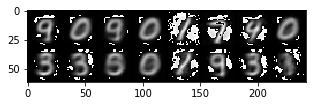

[0/100][199/600][200] Sinkhorn_Loss: 3.063641


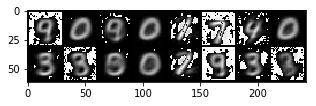

[0/100][299/600][300] Sinkhorn_Loss: 3.169014


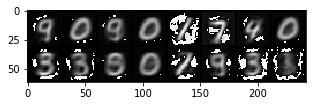

[0/100][399/600][400] Sinkhorn_Loss: 3.106504


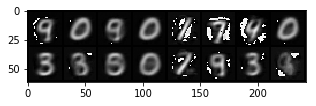

[0/100][499/600][500] Sinkhorn_Loss: 3.246855


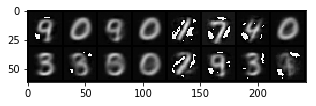

[0/100][599/600][600] Sinkhorn_Loss: 3.129062


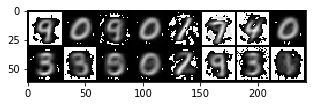

[1/100][99/600][700] Sinkhorn_Loss: 3.238861


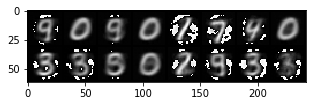

[1/100][199/600][800] Sinkhorn_Loss: 3.189435


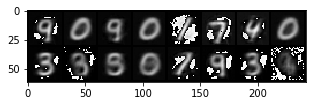

[1/100][299/600][900] Sinkhorn_Loss: 2.983685


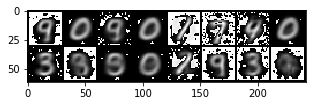

[1/100][399/600][1000] Sinkhorn_Loss: 3.284200


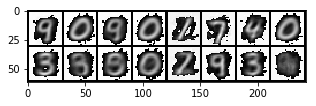

[1/100][499/600][1100] Sinkhorn_Loss: 2.895576


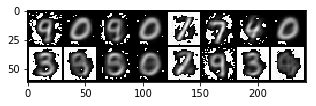

[1/100][599/600][1200] Sinkhorn_Loss: 3.300405


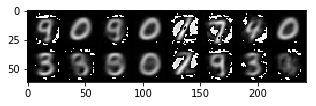

[2/100][99/600][1300] Sinkhorn_Loss: 2.904302


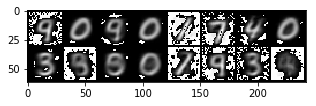

[2/100][199/600][1400] Sinkhorn_Loss: 3.389891


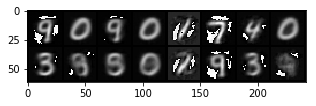

[2/100][299/600][1500] Sinkhorn_Loss: 3.084082


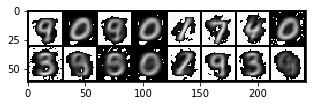

[2/100][399/600][1600] Sinkhorn_Loss: 3.285580


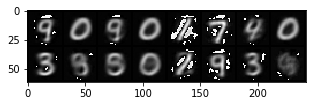

[2/100][499/600][1700] Sinkhorn_Loss: 3.060198


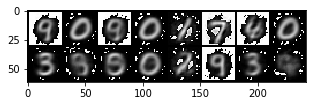

[2/100][599/600][1800] Sinkhorn_Loss: 3.119284


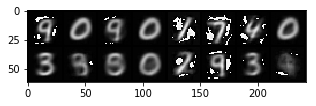

[3/100][99/600][1900] Sinkhorn_Loss: 3.270533


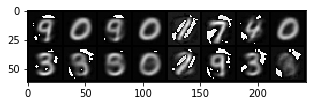

[3/100][199/600][2000] Sinkhorn_Loss: 3.167068


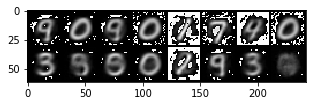

[3/100][299/600][2100] Sinkhorn_Loss: 2.966916


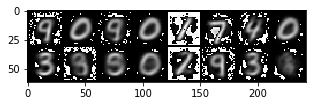

[3/100][399/600][2200] Sinkhorn_Loss: 3.134784


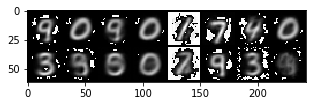

[3/100][499/600][2300] Sinkhorn_Loss: 3.084429


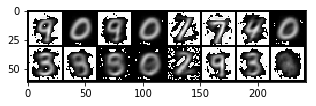

[3/100][599/600][2400] Sinkhorn_Loss: 3.341561


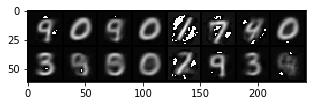

[4/100][99/600][2500] Sinkhorn_Loss: 3.219217


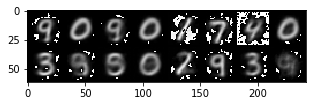

[4/100][199/600][2600] Sinkhorn_Loss: 3.205678


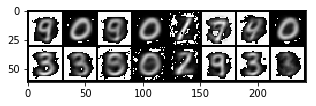

[4/100][299/600][2700] Sinkhorn_Loss: 2.957552


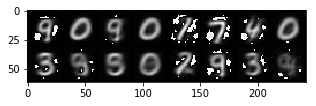

[4/100][399/600][2800] Sinkhorn_Loss: 3.097774


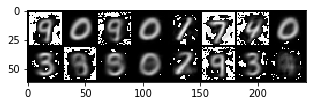

[4/100][499/600][2900] Sinkhorn_Loss: 3.187564


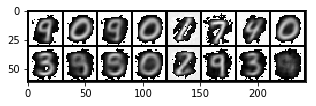

[4/100][599/600][3000] Sinkhorn_Loss: 3.038786


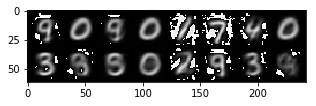

[5/100][99/600][3100] Sinkhorn_Loss: 2.899644


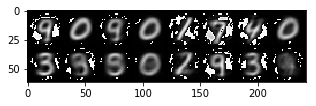

[5/100][199/600][3200] Sinkhorn_Loss: 2.908812


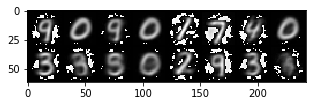

[5/100][299/600][3300] Sinkhorn_Loss: 2.965859


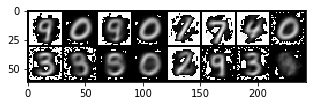

[5/100][399/600][3400] Sinkhorn_Loss: 2.999132


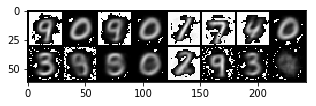

[5/100][499/600][3500] Sinkhorn_Loss: 3.247493


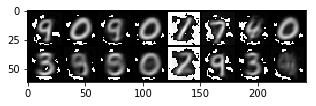

[5/100][599/600][3600] Sinkhorn_Loss: 3.131565


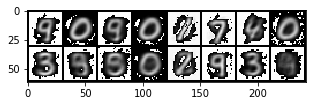

[6/100][99/600][3700] Sinkhorn_Loss: 3.127295


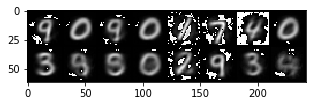

[6/100][199/600][3800] Sinkhorn_Loss: 3.283864


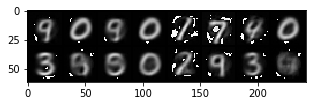

[6/100][299/600][3900] Sinkhorn_Loss: 3.023246


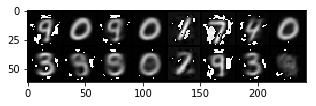

[6/100][399/600][4000] Sinkhorn_Loss: 2.897741


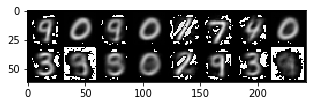

[6/100][499/600][4100] Sinkhorn_Loss: 3.099513


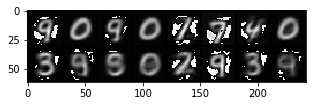

[6/100][599/600][4200] Sinkhorn_Loss: 3.057900


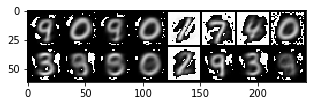

[7/100][99/600][4300] Sinkhorn_Loss: 3.055370


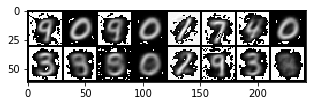

[7/100][199/600][4400] Sinkhorn_Loss: 3.060052


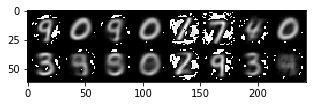

[7/100][299/600][4500] Sinkhorn_Loss: 2.915170


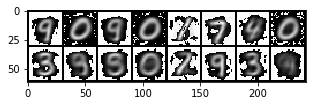

[7/100][399/600][4600] Sinkhorn_Loss: 2.990477


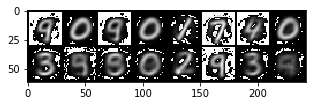

[7/100][499/600][4700] Sinkhorn_Loss: 3.025548


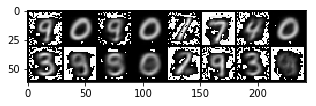

[7/100][599/600][4800] Sinkhorn_Loss: 3.034383


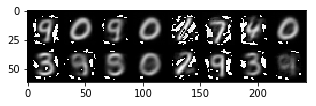

[8/100][99/600][4900] Sinkhorn_Loss: 2.887671


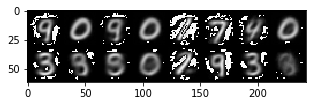

[8/100][199/600][5000] Sinkhorn_Loss: 3.132172


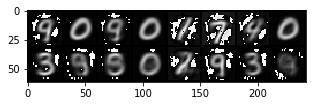

[8/100][299/600][5100] Sinkhorn_Loss: 2.994028


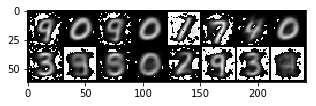

[8/100][399/600][5200] Sinkhorn_Loss: 3.021599


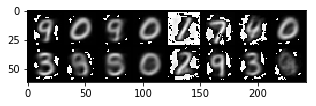

[8/100][499/600][5300] Sinkhorn_Loss: 3.110888


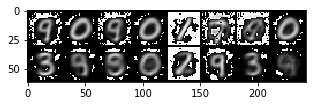

[8/100][599/600][5400] Sinkhorn_Loss: 2.862556


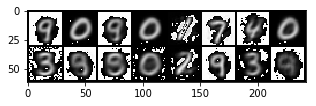

[9/100][99/600][5500] Sinkhorn_Loss: 3.003186


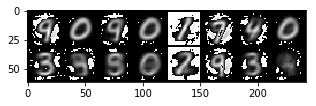

[9/100][199/600][5600] Sinkhorn_Loss: 3.249400


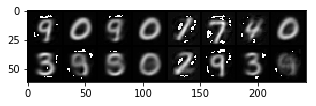

[9/100][299/600][5700] Sinkhorn_Loss: 3.039395


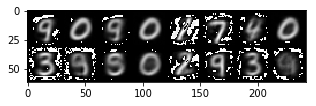

[9/100][399/600][5800] Sinkhorn_Loss: 3.056269


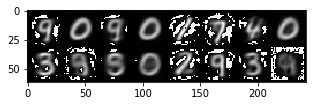

[9/100][499/600][5900] Sinkhorn_Loss: 2.906554


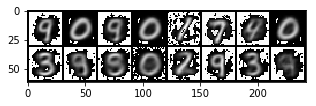

[9/100][599/600][6000] Sinkhorn_Loss: 2.999061


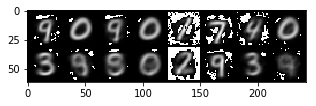

[10/100][99/600][6100] Sinkhorn_Loss: 3.026149


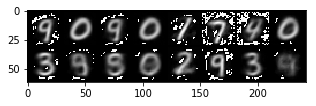

[10/100][199/600][6200] Sinkhorn_Loss: 3.027580


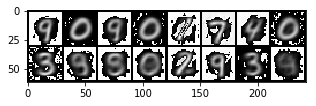

[10/100][299/600][6300] Sinkhorn_Loss: 2.933693


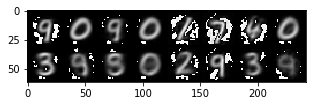

[10/100][399/600][6400] Sinkhorn_Loss: 2.830164


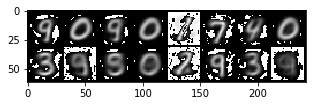

[10/100][499/600][6500] Sinkhorn_Loss: 3.202214


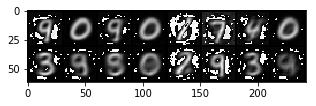

[10/100][599/600][6600] Sinkhorn_Loss: 3.020571


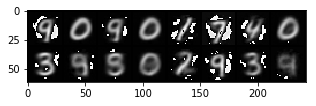

[11/100][99/600][6700] Sinkhorn_Loss: 2.955776


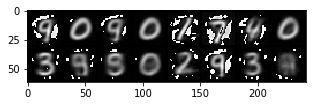

[11/100][199/600][6800] Sinkhorn_Loss: 3.108823


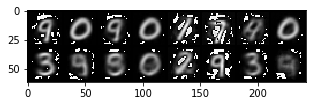

[11/100][299/600][6900] Sinkhorn_Loss: 3.134207


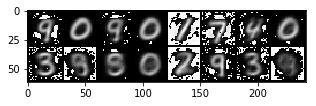

[11/100][399/600][7000] Sinkhorn_Loss: 3.155456


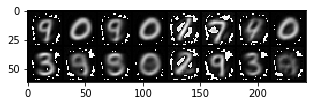

[11/100][499/600][7100] Sinkhorn_Loss: 2.885826


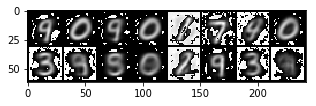

[11/100][599/600][7200] Sinkhorn_Loss: 2.974019


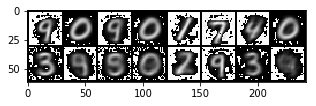

[12/100][99/600][7300] Sinkhorn_Loss: 3.220641


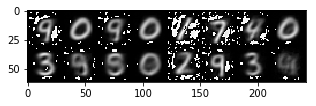

[12/100][199/600][7400] Sinkhorn_Loss: 3.203631


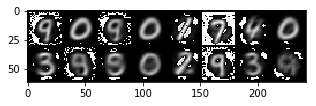

[12/100][299/600][7500] Sinkhorn_Loss: 3.163335


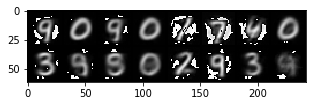

[12/100][399/600][7600] Sinkhorn_Loss: 3.317507


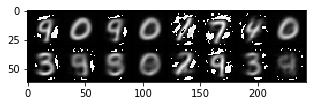

[12/100][499/600][7700] Sinkhorn_Loss: 3.091971


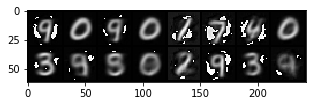

[12/100][599/600][7800] Sinkhorn_Loss: 2.995335


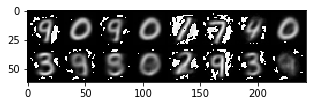

[13/100][99/600][7900] Sinkhorn_Loss: 2.932764


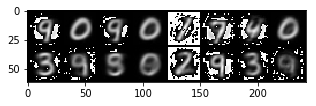

[13/100][199/600][8000] Sinkhorn_Loss: 3.091520


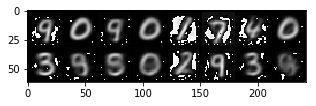

[13/100][299/600][8100] Sinkhorn_Loss: 3.379553


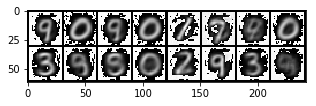

[13/100][399/600][8200] Sinkhorn_Loss: 3.247781


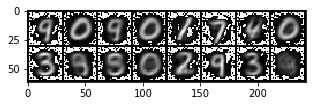

[13/100][499/600][8300] Sinkhorn_Loss: 3.069853


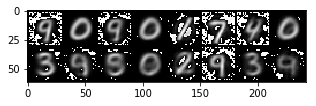

[13/100][599/600][8400] Sinkhorn_Loss: 3.043611


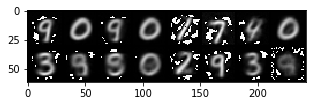

[14/100][99/600][8500] Sinkhorn_Loss: 3.077353


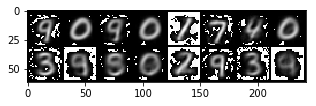

[14/100][199/600][8600] Sinkhorn_Loss: 3.006769


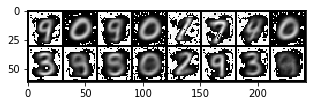

[14/100][299/600][8700] Sinkhorn_Loss: 2.991163


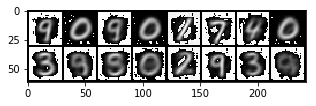

[14/100][399/600][8800] Sinkhorn_Loss: 3.139482


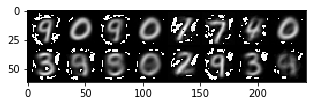

[14/100][499/600][8900] Sinkhorn_Loss: 3.179231


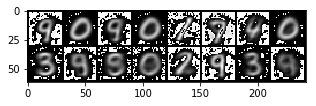

[14/100][599/600][9000] Sinkhorn_Loss: 3.092535


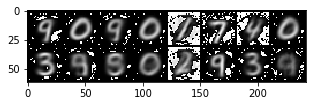

[15/100][99/600][9100] Sinkhorn_Loss: 3.011553


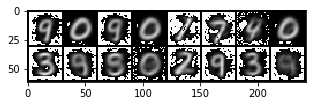

[15/100][199/600][9200] Sinkhorn_Loss: 2.898086


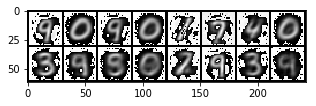

[15/100][299/600][9300] Sinkhorn_Loss: 2.907326


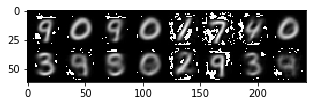

[15/100][399/600][9400] Sinkhorn_Loss: 3.050721


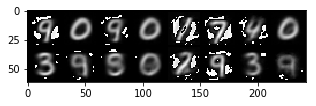

[15/100][499/600][9500] Sinkhorn_Loss: 3.061223


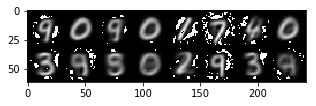

[15/100][599/600][9600] Sinkhorn_Loss: 3.072498


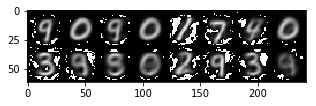

[16/100][99/600][9700] Sinkhorn_Loss: 3.069731


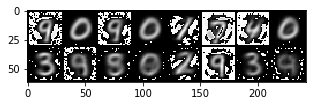

[16/100][199/600][9800] Sinkhorn_Loss: 3.001904


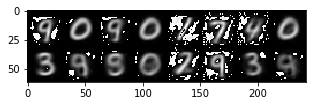

[16/100][299/600][9900] Sinkhorn_Loss: 3.067069


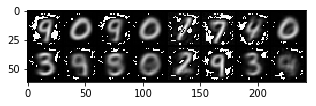

[16/100][399/600][10000] Sinkhorn_Loss: 3.265670


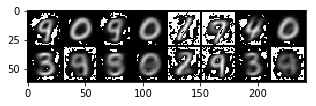

[16/100][499/600][10100] Sinkhorn_Loss: 3.097357


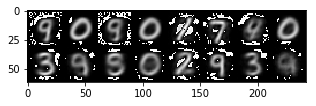

[16/100][599/600][10200] Sinkhorn_Loss: 2.874669


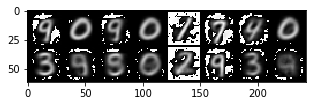

[17/100][99/600][10300] Sinkhorn_Loss: 3.007102


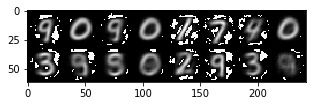

[17/100][199/600][10400] Sinkhorn_Loss: 2.931483


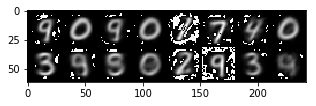

[17/100][299/600][10500] Sinkhorn_Loss: 2.872189


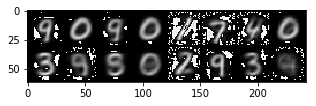

[17/100][399/600][10600] Sinkhorn_Loss: 2.970814


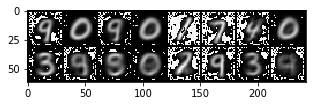

[17/100][499/600][10700] Sinkhorn_Loss: 2.972605


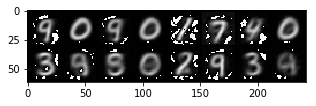

[17/100][599/600][10800] Sinkhorn_Loss: 3.102326


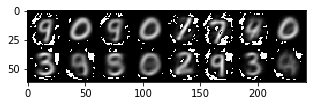

[18/100][99/600][10900] Sinkhorn_Loss: 2.728344


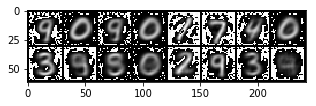

[18/100][199/600][11000] Sinkhorn_Loss: 2.913879


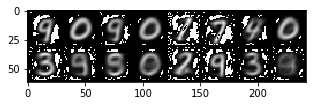

[18/100][299/600][11100] Sinkhorn_Loss: 2.943997


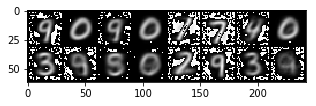

[18/100][399/600][11200] Sinkhorn_Loss: 3.276443


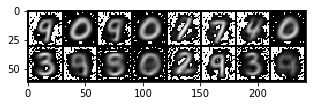

[18/100][499/600][11300] Sinkhorn_Loss: 2.996169


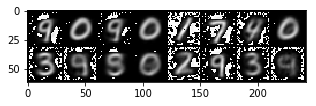

[18/100][599/600][11400] Sinkhorn_Loss: 3.007766


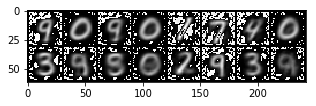

[19/100][99/600][11500] Sinkhorn_Loss: 3.061344


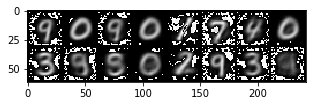

[19/100][199/600][11600] Sinkhorn_Loss: 3.038444


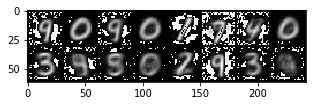

[19/100][299/600][11700] Sinkhorn_Loss: 3.065993


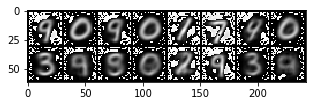

[19/100][399/600][11800] Sinkhorn_Loss: 2.977335


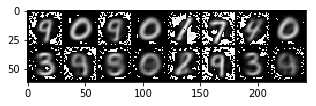

[19/100][499/600][11900] Sinkhorn_Loss: 3.064849


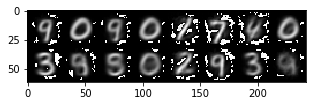

[19/100][599/600][12000] Sinkhorn_Loss: 2.943981


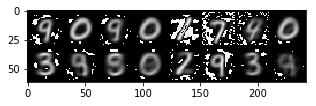

[20/100][99/600][12100] Sinkhorn_Loss: 3.178065


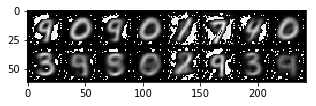

[20/100][199/600][12200] Sinkhorn_Loss: 3.044623


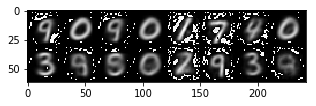

[20/100][299/600][12300] Sinkhorn_Loss: 2.855881


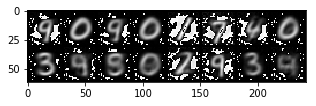

[20/100][399/600][12400] Sinkhorn_Loss: 3.012355


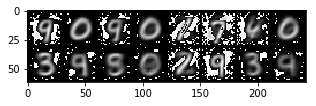

[20/100][499/600][12500] Sinkhorn_Loss: 2.971917


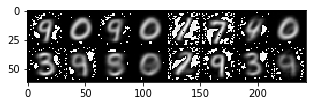

[20/100][599/600][12600] Sinkhorn_Loss: 3.028626


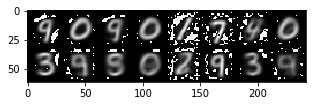

[21/100][99/600][12700] Sinkhorn_Loss: 2.940887


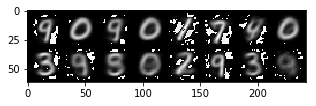

[21/100][199/600][12800] Sinkhorn_Loss: 3.024841


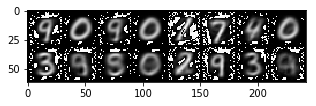

[21/100][299/600][12900] Sinkhorn_Loss: 2.834497


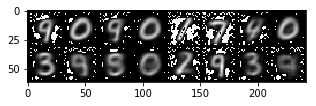

[21/100][399/600][13000] Sinkhorn_Loss: 2.957411


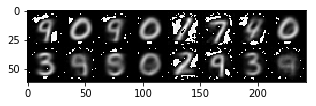

[21/100][499/600][13100] Sinkhorn_Loss: 3.094773


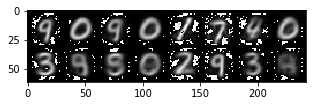

[21/100][599/600][13200] Sinkhorn_Loss: 2.862337


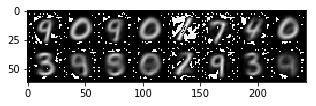

[22/100][99/600][13300] Sinkhorn_Loss: 3.104441


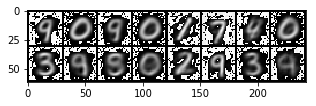

[22/100][199/600][13400] Sinkhorn_Loss: 3.059122


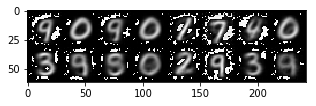

[22/100][299/600][13500] Sinkhorn_Loss: 3.006938


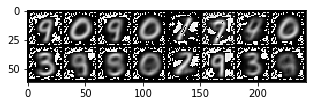

[22/100][399/600][13600] Sinkhorn_Loss: 3.249834


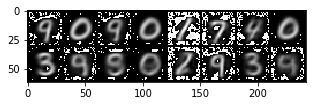

[22/100][499/600][13700] Sinkhorn_Loss: 3.199368


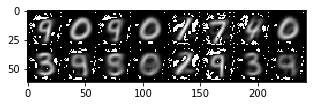

[22/100][599/600][13800] Sinkhorn_Loss: 2.907341


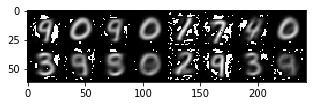

[23/100][99/600][13900] Sinkhorn_Loss: 2.903743


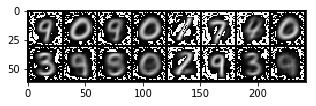

[23/100][199/600][14000] Sinkhorn_Loss: 3.060339


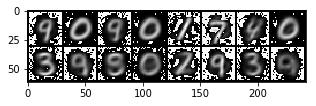

[23/100][299/600][14100] Sinkhorn_Loss: 3.118815


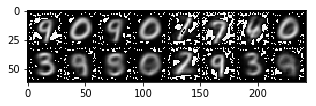

[23/100][399/600][14200] Sinkhorn_Loss: 2.880075


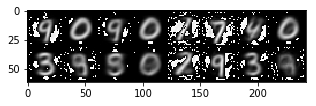

[23/100][499/600][14300] Sinkhorn_Loss: 2.968247


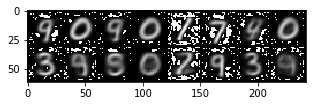

[23/100][599/600][14400] Sinkhorn_Loss: 3.072854


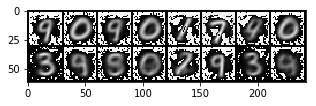

[24/100][99/600][14500] Sinkhorn_Loss: 3.114671


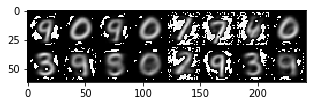

[24/100][199/600][14600] Sinkhorn_Loss: 2.980587


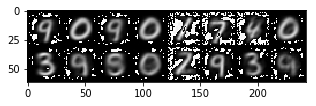

[24/100][299/600][14700] Sinkhorn_Loss: 3.130411


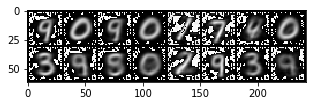

[24/100][399/600][14800] Sinkhorn_Loss: 2.956422


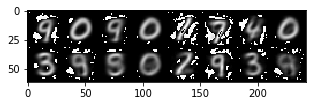

[24/100][499/600][14900] Sinkhorn_Loss: 2.807628


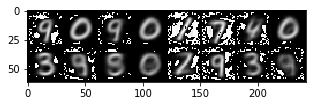

[24/100][599/600][15000] Sinkhorn_Loss: 2.931626


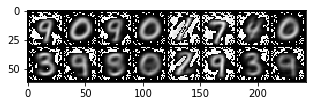

[25/100][99/600][15100] Sinkhorn_Loss: 3.044926


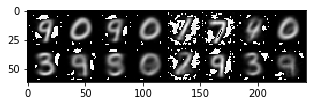

[25/100][199/600][15200] Sinkhorn_Loss: 3.013407


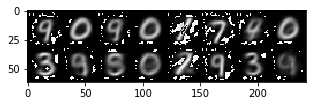

[25/100][299/600][15300] Sinkhorn_Loss: 2.922260


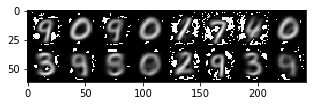

[25/100][399/600][15400] Sinkhorn_Loss: 2.864201


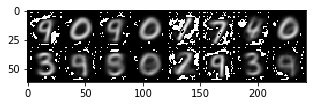

[25/100][499/600][15500] Sinkhorn_Loss: 2.983480


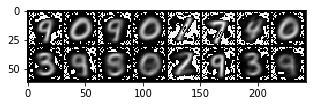

[25/100][599/600][15600] Sinkhorn_Loss: 2.872970


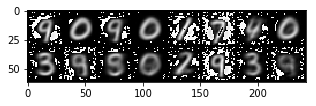

[26/100][99/600][15700] Sinkhorn_Loss: 3.048990


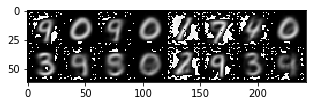

[26/100][199/600][15800] Sinkhorn_Loss: 2.990430


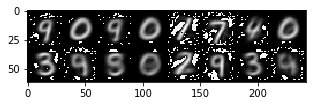

[26/100][299/600][15900] Sinkhorn_Loss: 2.975131


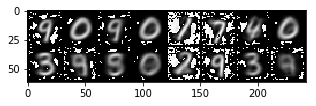

[26/100][399/600][16000] Sinkhorn_Loss: 2.934916


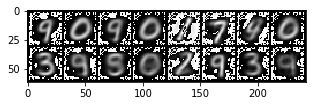

[26/100][499/600][16100] Sinkhorn_Loss: 2.853602


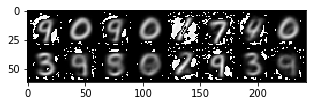

[26/100][599/600][16200] Sinkhorn_Loss: 2.973947


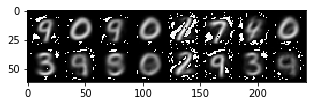

[27/100][99/600][16300] Sinkhorn_Loss: 3.002830


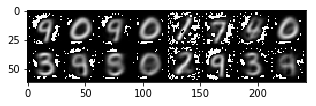

[27/100][199/600][16400] Sinkhorn_Loss: 2.871685


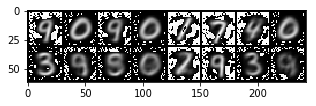

[27/100][299/600][16500] Sinkhorn_Loss: 3.048851


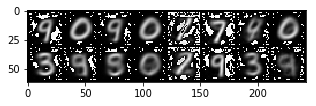

[27/100][399/600][16600] Sinkhorn_Loss: 2.887126


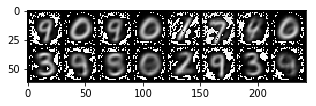

[27/100][499/600][16700] Sinkhorn_Loss: 3.026020


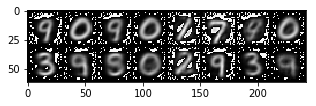

[27/100][599/600][16800] Sinkhorn_Loss: 3.101145


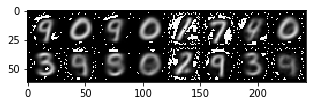

[28/100][99/600][16900] Sinkhorn_Loss: 3.140975


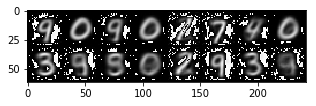

[28/100][199/600][17000] Sinkhorn_Loss: 2.908190


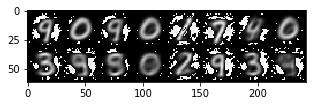

[28/100][299/600][17100] Sinkhorn_Loss: 2.965919


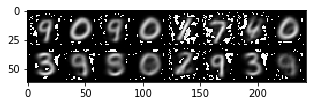

[28/100][399/600][17200] Sinkhorn_Loss: 3.048251


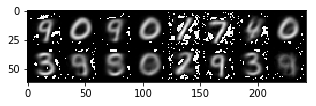

[28/100][499/600][17300] Sinkhorn_Loss: 2.868636


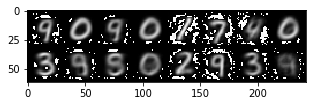

In [ ]:

gen_iterations = 0
for epoch in range(niter):
    
    data_iter = iter(dataloader)
    i = 0
    while i < len(dataloader):
        
        ############################
        # (2) Update G network
        ###########################
        data = data_iter.next()
        real_cpu, _ = data
        if cuda and torch.cuda.is_available():
            real_cpu = real_cpu.cuda()
        netG.zero_grad()
        # in case our last batch was the tail batch of the dataloader,
        # make sure we feed a full batch of noise
        noise.resize_(batchSize, nz).normal_(0, 1)
        if cuda and torch.cuda.is_available():
            noise = noise.cuda()
        noisev = Variable(noise, requires_grad = False)
        fake = netG(noisev)
        #Tracer()()
        input.resize_as_(real_cpu).copy_(real_cpu)
        inputv = Variable(input, requires_grad = False)
        loss = sinkhorn_normalized(fake, inputv, epsilon, batchSize, L) #- compute_sinkhorn_loss(batchSize, fake, fake, epsilon, L) - compute_sinkhorn_loss(batchSize, inputv, inputv, epsilon, L)
        loss.backward(one)
        optimizerG.step()
        gen_iterations += 1
        
        if gen_iterations % 100== 0:
            print('[%d/%d][%d/%d][%d] Sinkhorn_Loss: %f'
            % (epoch, niter, i, len(dataloader), gen_iterations,
            loss.data[0]))
            real_cpu = real_cpu.mul(0.5).add(0.5)
            vutils.save_image(real_cpu, '{0}/real_samples_sinkhorn.png'.format(experiment))
            fake = netG(Variable(fixed_noise, volatile=True))
            fake.data = fake.data.mul(0.5).add(0.5)
            vutils.save_image(fake.data, '{0}/fake_samples_sinkhorn.png'.format(experiment))
            if cuda and torch.cuda.is_available():
                dd = utils.make_grid(fake.cpu().data[:16])
            else:
                dd = utils.make_grid(fake.data[:16]) 
            imshow(dd)
            # do checkpointing"
            torch.save(netG.state_dict(), '{0}/netG_sinkhorn.pth'.format(experiment))
        i += 1

    